# Deep-LDA - Alanine dipeptide

Tutorial for the training of the Deep-LDA collective variable, using the Alanine Dipeptide system as example with the interatomic distances as input descriptors.

Reference: _Bonati, Rizzi and Parrinello, J. Phys. Chem. Lett., 11, 2998-3004 (2020)_.

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Plotting functions

In [2]:
def plot_ramachandran(x,y,z,scatter=None,ax=None):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'Ramachandran plot')

    # Plot countour plot
    h = ax.hexbin(x,y,C=z,cmap='fessa')
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'Deep-LDA CV')

    axs[0].set_xlabel(r'$\phi$ [rad]')
    axs[0].set_ylabel(r'$\psi$ [rad]')

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)


### Load data

Load the descriptors from PLUMED COLVAR files (one unbiased run for every metastable state).

In [3]:
from mlcvs.utils.io import load_dataframe

filenames = [ "data/ala2_md/COLVAR_stateA", "data/ala2_md/COLVAR_stateB" ]

X, y = [], []

for i, file in enumerate(filenames):
    data = load_dataframe(file)[::4]

    # Descriptors
    selection = 'd'
    X.append( data.filter(regex=selection).values )
    names = data.filter(regex=selection).columns.values

    # Labels
    y.append( np.full(len(data),i) )

X = torch.Tensor( np.vstack(X) )
y = torch.Tensor( np.hstack(y) )

n_features = X.shape[1]

Create a dataset, split in train and validation, and initialize a `FastTensorDataLoader' for efficient training.

In [4]:
from torch.utils.data import TensorDataset,random_split
from mlcvs.utils.data import FastTensorDataLoader

dataset = TensorDataset(X,y)
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_data, valid_data = random_split(dataset,[train_size,valid_size])
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

### Train CV

Inizialize the neural network and the optimizer and define when to stop the training (EarlyStopping or after a given number of epochs).

| Parameter | Type | Description |
| :- | :- | :- |
| **Neural network** |
| nodes | list | NN architecture (last value equal to the number of hidden layers which are input of LDA) |
| activ_type | string | Activation function (relu,tanh,elu,linear) |
| n_eig | int | Number of eigenvalues to optimize (or if loss_type=single which one to select) |
| **Optimization** |
| lrate | float | Learning rate |
| sw_reg | float | S_w matrix regularization | 
| l2_reg | float | L2 regularization |
| num_epochs | int | Number of epochs |
| **Early Stopping** |
| earlystop | bool | Whether to use early stopping based on validation loss |
| es_patience | int | Number of epochs before stopping |
| es_consecutive | bool | Whether es_patience should count consecutive (True) or cumulative patience |
| es_min_delta | float | Minimum decrease of validation loss |
| **Log** |
| log_every | int | How often print the train/valid loss during training |


In [5]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [n_features,30,30,5]

lrate             = 0.001
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 1000
earlystop         = True
es_patience       = 20
es_consecutive    = True
es_min_delta      = 0.02

log_every         = 100
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepLDA_CV(nodes)
model.set_device(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)
model.set_optimizer(opt)

# REGULARIZATION
model.set_regularization(sw_reg=sw_reg)
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# TRAIN
model.fit(train_loader, valid_loader, standardize_inputs = True, log_every=log_every)

# standardize outputs
#model.standardize_outputs(train_data[0].to(device))

[Warning] Normalization: the following features have a range of values < 1e-6: tensor([[ 0],
        [ 9],
        [10],
        [24],
        [30],
        [31],
        [39],
        [40],
        [44]])
Epoch Train Loss  Valid Loss  
100   -48.624 -48.742 
200   -62.406 -62.404 
300   -62.592 -62.605 
400   -62.640 -62.652 
500   -62.663 -62.671 
600   -62.672 -62.670 
700   -62.664 -62.675 
800   -62.674 -62.676 
900   -62.698 -62.697 
1000  -62.709 -62.715 


In [6]:
# get back to CPU
model.to('cpu')

DeepLDA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)

### Plot learning curve

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

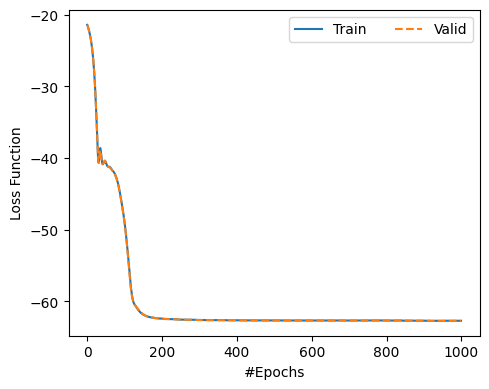

In [7]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)

loss_train = [x for x in model.logs['loss_train']]
loss_valid = [x for x in model.logs['loss_valid']]

# Loss function
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

#if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

### Plot results

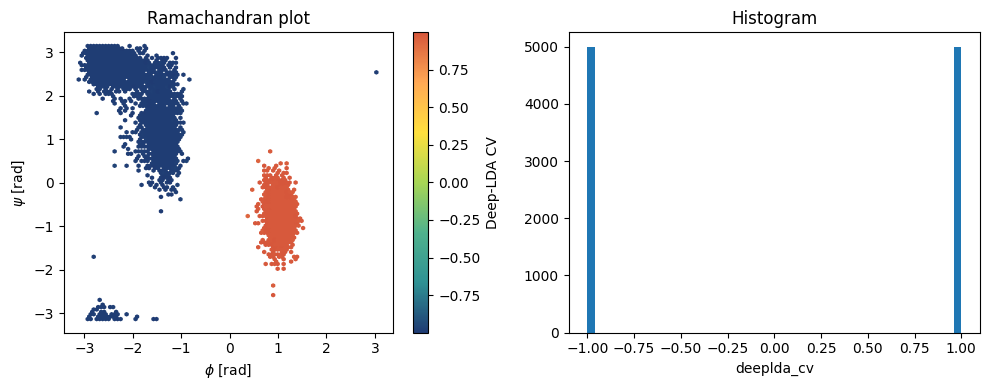

In [8]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

# Ramachandran plot
##  Read phi and psi data from colvar files
phi, psi = [], []

for i, file in enumerate(filenames):
    data = load_dataframe(file)[::4]
    # compute them from sin and cos
    phi.append(np.arctan2(data['sin1'],data['cos1']) ) 
    psi.append(np.arctan2(data['sin2'],data['cos2']) ) 

phi = np.hstack(phi)
psi = np.hstack(psi)
## 

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
plot_ramachandran(phi,psi,s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()